In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 100

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Crop_disease',
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 7475 files belonging to 27 classes.


In [4]:
class_names = dataset.class_names

In [5]:
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [6]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

(32, 256, 256, 3)
[13  1 25 12  8 20 25 20  1 25 13  3 13 13 17  9  7  3 13  1  1  9 10 26
  2  3 14 19 25 13 13 12]


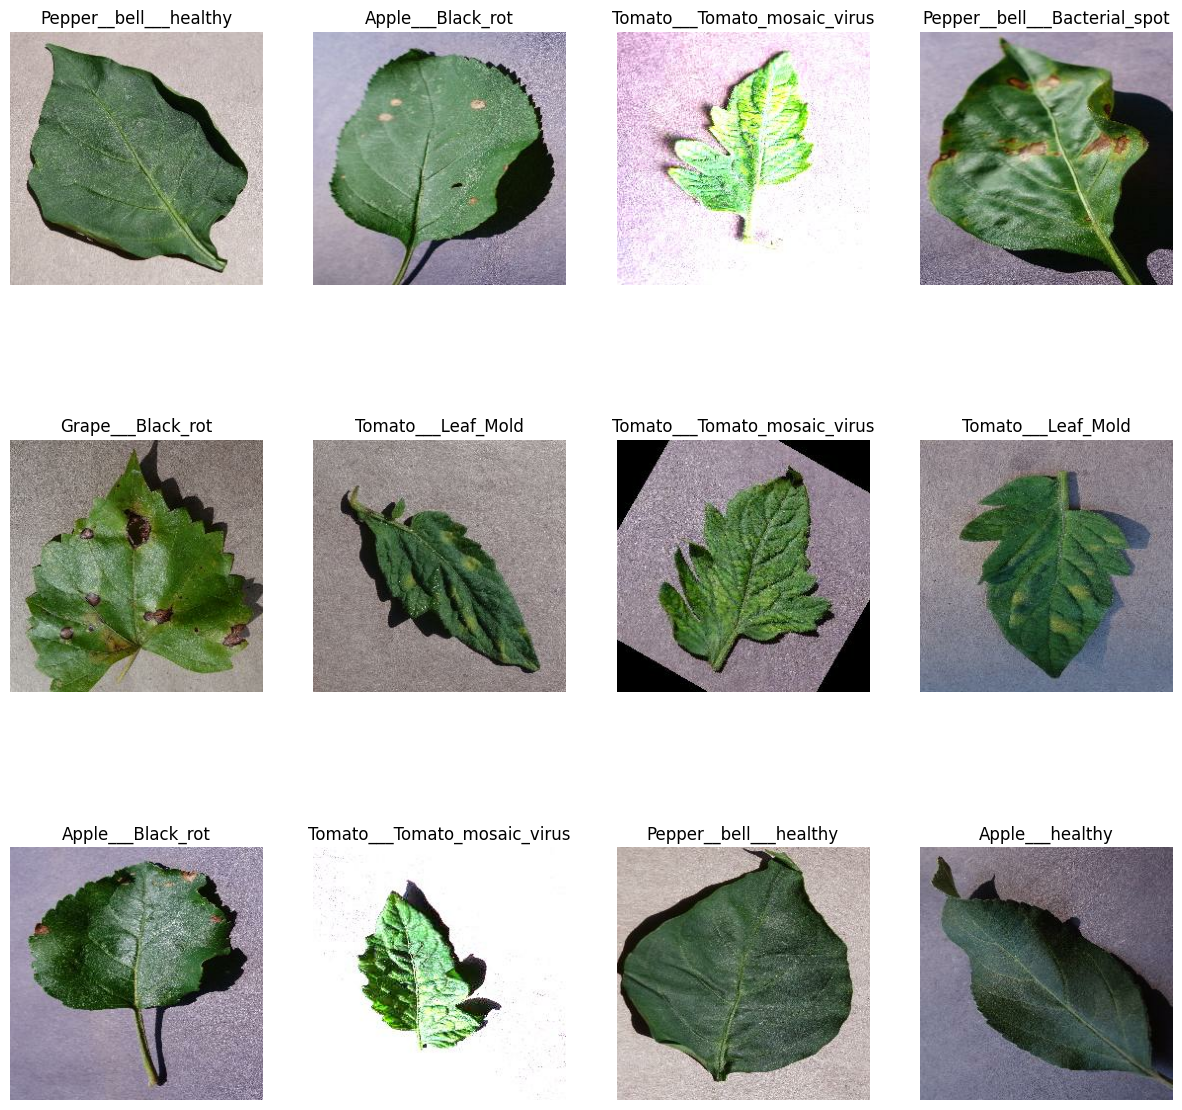

In [7]:
plt.figure(figsize=(15,15))
for image_batch , labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')

In [8]:
def get_dataset_partition_tf(ds, train_split = 0.8 , val_split = 0.1 , test_split = 0.1 , shuffle = True , shuffle_size=10000):
    assert(train_split+val_split+test_split) == 1
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size , seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds , val_ds , test_ds

In [9]:
train_ds , val_ds , test_ds = get_dataset_partition_tf(dataset)

In [10]:
len(train_ds)

187

In [11]:
len(val_ds)

23

In [12]:
len(test_ds)

24

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
for image_batch , labels_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0.79607844 0.78431374 0.8117647 ]
  [0.7921569  0.78039217 0.80784315]
  [0.7921569  0.78039217 0.80784315]
  ...
  [0.6313726  0.6156863  0.61960787]
  [0.6509804  0.63529414 0.6392157 ]
  [0.59607846 0.5803922  0.58431375]]

 [[0.8        0.7882353  0.8156863 ]
  [0.79607844 0.78431374 0.8117647 ]
  [0.79607844 0.78431374 0.8117647 ]
  ...
  [0.6784314  0.6627451  0.6666667 ]
  [0.69803923 0.68235296 0.6862745 ]
  [0.654902   0.6392157  0.6431373 ]]

 [[0.8039216  0.7921569  0.81960785]
  [0.8        0.7882353  0.8156863 ]
  [0.79607844 0.78431374 0.8117647 ]
  ...
  [0.6745098  0.65882355 0.6627451 ]
  [0.6901961  0.6745098  0.6784314 ]
  [0.6627451  0.64705884 0.6509804 ]]

 ...

 [[0.6862745  0.6784314  0.72156864]
  [0.6784314  0.67058825 0.7137255 ]
  [0.68235296 0.6745098  0.7176471 ]
  ...
  [0.5372549  0.5254902  0.56078434]
  [0.5294118  0.5176471  0.5529412 ]
  [0.53333336 0.52156866 0.5568628 ]]

 [[0.6745098  0.6666667  0.70980394]
  [0.65882355 0.6509804  0.69411767]


In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

In [17]:
input_shape = (32, IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 27

In [18]:
model = models.Sequential([
    layers.InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    resize_and_rescale,  # Resizing and rescaling layer
    data_augmentation,   # Data augmentation layer
    
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    # Adding a global pooling layer to reduce dimensions before flattening
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])


# Model summary
model.summary()

c:\Users\Arpan\Downloads\SIH_hackathon\sih\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 27)             │         1,755 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 505,051 (1.93 MB)

 Trainable params: 505,051 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [20]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = EPOCHS
)

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 109s 561ms/step - accuracy: 0.1924 - loss: 3.0354 - val_accuracy: 0.2582 - val_loss: 2.6262
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 102s 545ms/step - accuracy: 0.2762 - loss: 2.4710 - val_accuracy: 0.3424 - val_loss: 2.1194
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 96s 513ms/step - accuracy: 0.3612 - loss: 2.0653 - val_accuracy: 0.4171 - val_loss: 1.8460
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 98s 526ms/step - accuracy: 0.4345 - loss: 1.8010 - val_accuracy: 0.5462 - val_loss: 1.4559
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 101s 539ms/step - accuracy: 0.5241 - loss: 1.5290 - val_accuracy: 0.4796 - val_loss: 1.7612
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 103s 551ms/step - accuracy: 0.5864 - loss: 1.2669 - val_accuracy: 0.5272 - val_loss: 1.5001
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 106s 565ms/step - accuracy: 0.6465 - loss: 1.1186 - val_accuracy: 0.6019 - val_loss: 1.2510
Epoch 8/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 168s 898ms/step - accuracy: 0.

In [21]:
scores = model.evaluate(test_ds)

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.9623 - loss: 0.1155


In [22]:
scores

[0.1080780029296875, 0.9635416865348816]

In [23]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 187}

In [25]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [27]:
len(history.history['loss'])

100

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

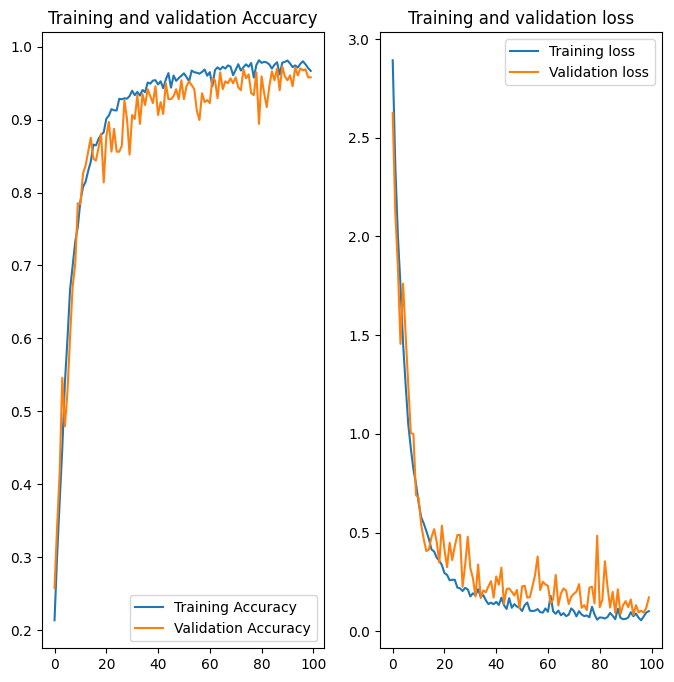

In [30]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc , label= 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation Accuarcy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss , label= 'Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and validation loss')
plt.show()

First image to predict
Actual Label: Pepper__bell___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Predicted Label Pepper__bell___healthy


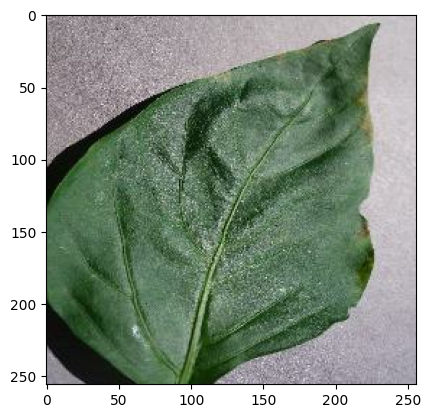

In [76]:
import numpy as np
for images_batch , labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    
    print('First image to predict')
    plt.imshow(first_image)
    print('Actual Label:',class_names[labels_batch[0].numpy()])

    batch_prediction = model.predict(images_batch)
    print('Predicted Label',class_names[np.argmax(batch_prediction[0])])
    

In [77]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


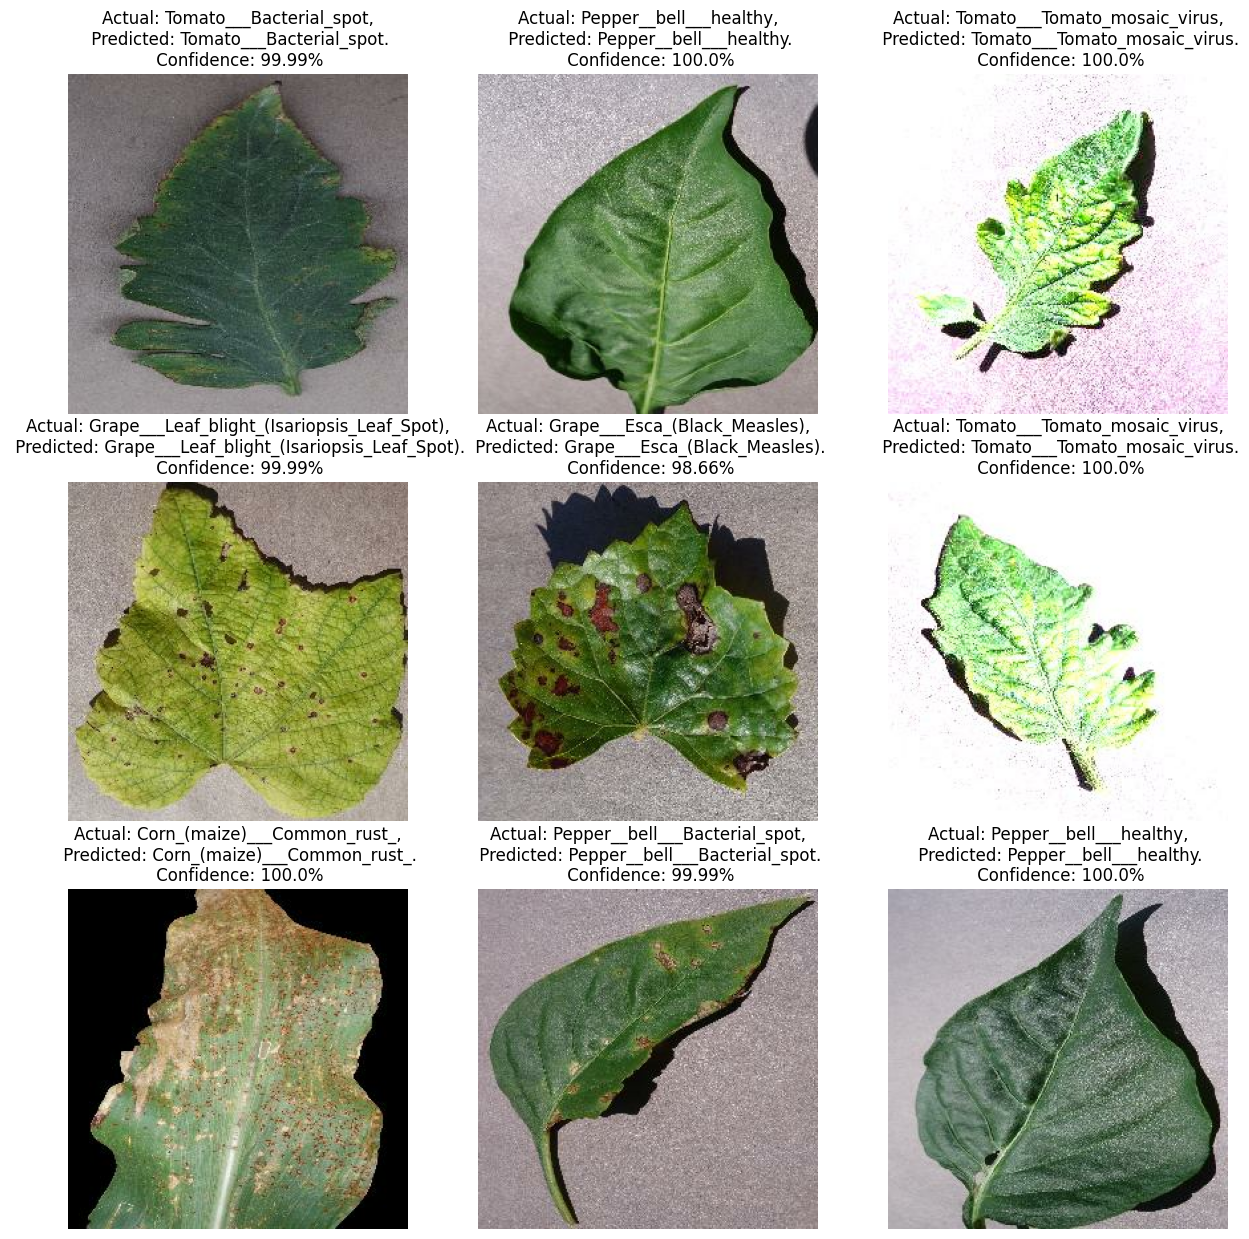

In [78]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [89]:
model.save('my_model.keras')